# **Клонирование репозитория**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/Aribaldi/Mlinreg '/content/drive/MyDrive/Mlinreg/'

Cloning into '/content/drive/MyDrive/Mlinreg'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 97 (delta 49), reused 46 (delta 17), pack-reused 0
Unpacking objects: 100% (97/97), done.


In [ ]:
%cd  /content/drive/MyDrive/Mlinreg/
!git status

/content/drive/MyDrive/Mlinreg
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [ ]:
!git fetch

In [ ]:
!git pull

Already up to date.


# **Скачка данных**

In [1]:
import os
import pandas as pd
import glob

In [ ]:
START_YEAR = 2020
START_MONTH = 1
END_YEAR = 2020
END_MONTH = 3
SAVE_PATH = 'data/'

In [ ]:
if not os.path.exists('data/'):
    os.makedirs('data/')

!sh utils/downloader.sh {START_MONTH} {START_YEAR} {END_MONTH} {END_YEAR} {SAVE_PATH}

-----Downloading data for 2020-----
-----month 1-----
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5592  100   201  100  5391     16    441  0:00:12  0:00:12 --:--:--    54
Received <head><title>Object moved</title></head>
<body><h1>Object Moved</h1>This object may be found <a HREF="https://transtats.bts.gov/ftproot/TranStatsData/275752072_T_ONTIME_REPORTING.zip">here</a>.</body>
https://transtats.bts.gov/ftproot/TranStatsData/275752072_T_ONTIME_REPORTING.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.6M  100 16.6M    0     0   917k      0  0:00:18  0:00:18 --:--:-- 1440k
-----2020 1 download complete-----
-----Unzipping-----
Archive:  20201.zip
  inflating: 275752072_T_ONTIME_REPORTING.csv  
-----Removing old .zip file-----
-----done-----
-----Clean

# **Препроцессинг и разбиение на трейн/тест**

In [ ]:
columns = {
    'YEAR' : 'Year', 
    'MONTH' : 'Month', 
    'DAY_OF_MONTH' : 'DayofMonth', 
    'DAY_OF_WEEK' : 'DayOfWeek', 
    'DEP_TIME' : 'DepTime', 
    'CRS_DEP_TIME' : 'CRSDepTime',
    'ARR_TIME' : 'ArrTime',
    'CRS_ARR_TIME' : 'CRSArrTime',
    'OP_UNIQUE_CARRIER' : 'UniqueCarrier',
    'OP_CARRIER_FL_NUM' : 'FlightNum', 
    'TAIL_NUM' : 'TailNum', 
    'ACTUAL_ELAPSED_TIME' : 'ActualElapsedTime', 
    'CRS_ELAPSED_TIME' : 'CRSElapsedTime', 
    'AIR_TIME' : 'AirTime',
    'ARR_DELAY' : 'ArrDelay',
    'DEP_DELAY' : 'DepDelay',
    'ORIGIN' : 'Origin', 
    'DEST' : 'Dest', 
    'DISTANCE' : 'Distance',
    'TAXI_IN' : 'TaxiIn',
    'TAXI_OUT' : 'TaxiOut', 
    'CANCELLED' : 'Cancelled', 
    'CANCELLATION_CODE' : 'CancellationCode', 
    'DIVERTED' : 'Diverted',
    'CARRIER_DELAY' : 'CarrierDelay', 
    'WEATHER_DELAY' : 'WeatherDelay', 
    'NAS_DELAY' : 'NASDelay', 
    'SECURITY_DELAY' : 'SecurityDelay',
    'LATE_AIRCRAFT_DELAY' : 'LateAircraftDelay'
}

In [ ]:
os.chdir('data/')
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
combined_csv.rename(columns=columns, inplace=True)
combined_csv = combined_csv[list(columns.values())]
combined_csv.to_csv('raw.csv', index=False, encoding='utf-8-sig')
os.chdir('../')

In [2]:
raw = pd.read_csv('data/raw.csv')

In [3]:
raw

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2020,1,17,5,909.0,845,1418.0,1410,WN,458,...,5.0,13.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2020,1,17,5,552.0,550,1056.0,1110,WN,1469,...,2.0,10.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2020,1,17,5,NaN,1355,NaN,1930,WN,1486,...,NaN,NaN,1.0,B,0.0,NaN,NaN,NaN,NaN,NaN
3,2020,1,17,5,NaN,1640,NaN,2205,WN,1728,...,NaN,NaN,1.0,B,0.0,NaN,NaN,NaN,NaN,NaN
4,2020,1,17,5,739.0,740,1305.0,1305,WN,1744,...,17.0,8.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829838,2020,3,1,7,1534.0,1530,1916.0,1920,UA,201,...,3.0,24.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1829839,2020,3,1,7,732.0,740,1829.0,1845,UA,200,...,4.0,13.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1829840,2020,3,1,7,717.0,730,756.0,811,UA,174,...,4.0,11.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1829841,2020,3,1,7,849.0,915,925.0,955,UA,117,...,3.0,9.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


**Чистка**


*   Дроп лишних столбцов
*   Дроп отмененных и перенаправленных полетов
*   Приведение CRSDepTime из вида "часы*100+минуты" к минутам от начала дня



In [4]:
df = raw.drop(['Year', 'ArrTime', 'CRSArrTime', 'FlightNum', 'TailNum', 
               'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'TaxiIn', #'TaxiOut', 
               'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode', 'DepTime' ], axis=1)
df = df[(df.Cancelled != 1.) & (df.Diverted != 1.)]
df = df.drop(['Cancelled', 'Diverted'], axis=1)
df['CRSDepTime'].isna().sum()
temp = df['CRSDepTime'].to_numpy()
temp = list(map(lambda x: x // 100 * 60 + x % 100, temp))
df['CRSDepTime'] = pd.Series(temp, index=df.index)
df

,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,DepDelay,Origin,Dest,Distance,TaxiOut
0,1,17,5,525,WN,24.0,LAS,MDW,1521.0,13.0
1,1,17,5,350,WN,2.0,LAS,MDW,1521.0,10.0
4,1,17,5,460,WN,-1.0,LAS,MDW,1521.0,8.0
6,1,17,5,1160,WN,1.0,LAS,MKE,1524.0,11.0
7,1,17,5,560,WN,13.0,LAS,MKE,1524.0,17.0
...,...,...,...,...,...,...,...,...,...,...
1829838,3,1,7,930,UA,4.0,HNL,GUM,3801.0,24.0
1829839,3,1,7,460,UA,-8.0,GUM,HNL,3801.0,13.0
1829840,3,1,7,450,UA,-13.0,GUM,SPN,129.0,11.0
1829841,3,1,7,555,UA,-26.0,SPN,GUM,129.0,9.0


In [5]:
test_size = 0.1

In [6]:
test_df = df.sample(int(len(df)*0.1))
train_df = df.drop(test_df.index)

In [7]:
train_df.to_csv('data/train_df.csv', index=False)
test_df.to_csv('data/test_df.csv', index=False)

# **Анализ фич**

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('data/train_df.csv')

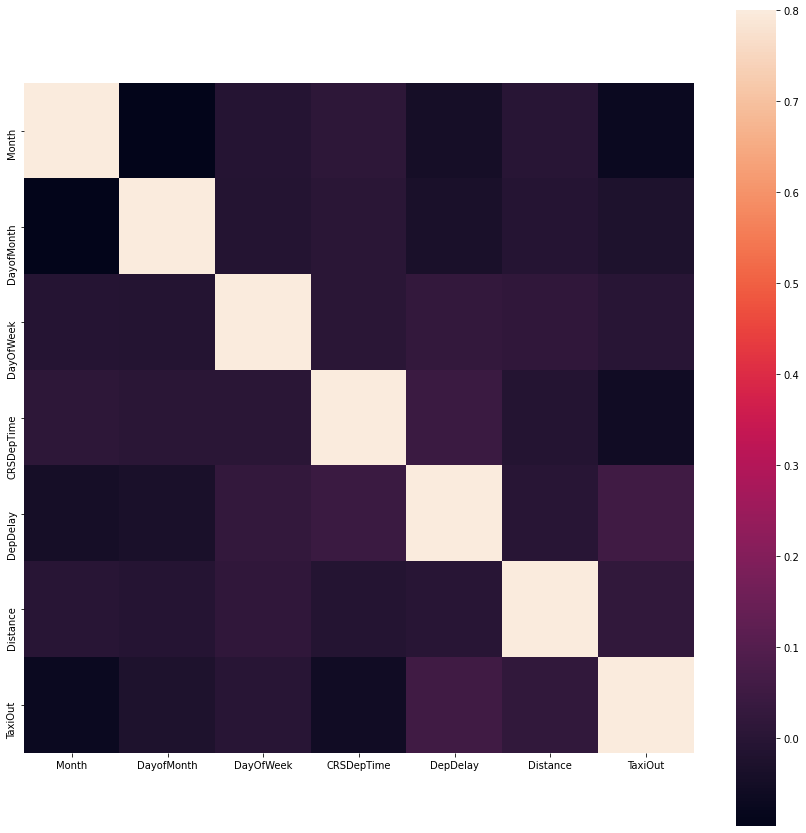

In [ ]:
cmat = df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(cmat, vmax=.8, square=True)
plt.show()

**Анализ множества значений различных фич**

In [ ]:
import numpy as np
carriers_list = np.unique(df['UniqueCarrier'].to_numpy())
print(f"Carriers list: \n {carriers_list}")
routs_count = df.groupby(['Origin', 'Dest']).size().reset_index().rename(columns={0:'count'})
print(f"Routs count: \n {routs_count}")
airports_list = np.unique(df['Origin'].to_numpy())
print(f"Airports num: {airports_list.shape}")

Carriers list: 
 ['9E' 'AA' 'AS' 'B6' 'DL' 'EV' 'F9' 'G4' 'HA' 'MQ' 'NK' 'OH' 'OO' 'UA'
 'WN' 'YV' 'YX']
Routs count: 
      Origin Dest  count
0       ABE  ATL    181
1       ABE  BNA      9
2       ABE  CLT    228
3       ABE  DTW    205
4       ABE  FLL     16
...     ...  ...    ...
5877    XWA  MSP    150
5878    YAK  CDV     69
5879    YAK  JNU     80
5880    YUM  DFW     82
5881    YUM  PHX    371

[5882 rows x 3 columns]
Airports num: (352,)


**Статистика по авиакомпаниям-перевозчикам**

In [ ]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
global_stats = df['DepDelay'].groupby(df['UniqueCarrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
UniqueCarrier,,,,
HA,-43.0,1483.0,17656.0,0.097021
G4,-66.0,1507.0,22676.0,7.774299
EV,-31.0,1290.0,28787.0,1.758780
F9,-39.0,645.0,30355.0,4.827870
YV,-56.0,1890.0,44367.0,8.021773
NK,-47.0,1083.0,47555.0,6.874125
AS,-80.0,823.0,52518.0,2.850908
9E,-41.0,1201.0,60193.0,4.144768
OH,-49.0,1919.0,60655.0,11.994378


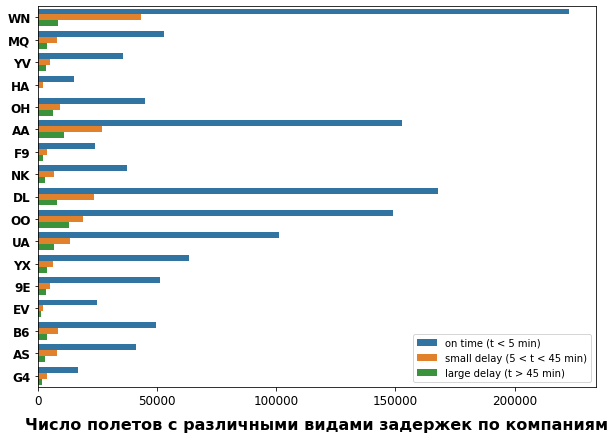

In [ ]:
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DelayLevel'] = df['DepDelay'].apply(delay_type)
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="UniqueCarrier", hue='DelayLevel', data=df)
labels = [item for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Число полетов с различными видами задержек по компаниям', fontsize=16, weight = 'bold', labelpad=10)
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

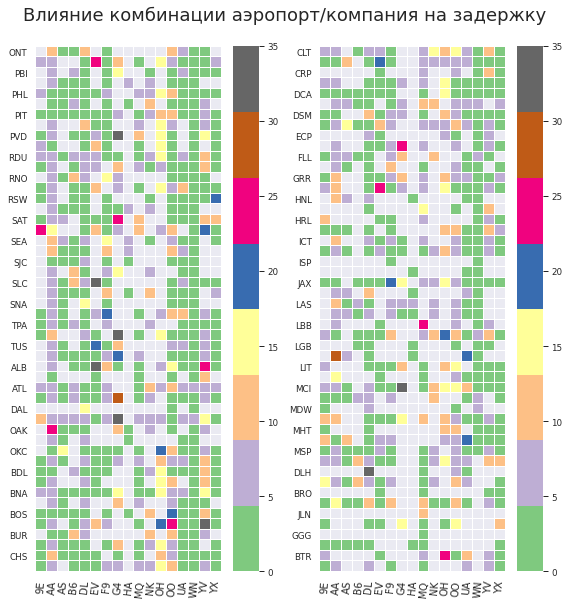

In [ ]:
airport_mean_delays = pd.DataFrame(pd.Series(df['Origin'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in carriers_list:
    df1 = df[df['UniqueCarrier'] == carrier]
    test = df1['DepDelay'].groupby(df['Origin']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:]
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:]
fig.text(0.5, 1.02, "Влияние комбинации аэропорт/компания на задержку", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

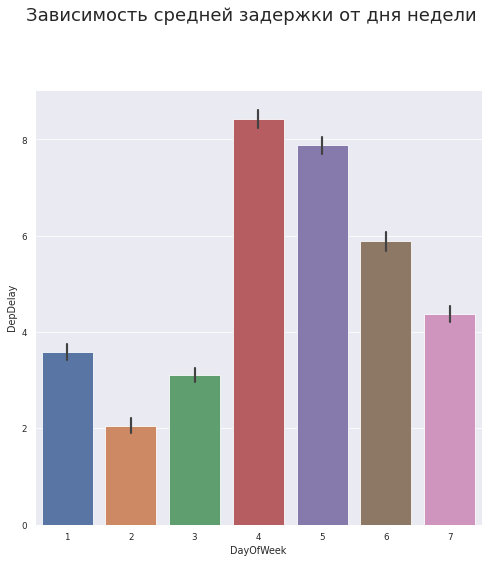

In [ ]:
fig = plt.figure(1, figsize=(8,8))
sns.barplot(x='DayOfWeek', y='DepDelay', data=df)
fig.text(0.5, 1., "Зависимость средней задержки от дня недели", ha='center', fontsize = 18)
plt.show()

# **Выбор фичей**

Опираясь на матрицу корреляций, выберем в качестве фичей CRSDepTime, DayOfWeek и UniqueCarrier (для последних 2-х применим one hot encoding).
Переменные, содержащие в себе лики (любые, значения которых известны только после вылета самолета) не рассматриваются в качестве фичей.

In [8]:
res = pd.read_csv('data/train_df.csv')
res = pd.concat([res, pd.get_dummies(res.UniqueCarrier), pd.get_dummies(res.DayOfWeek)], axis=1)
res = res.drop(['Month', 'Distance', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'TaxiOut'], axis=1)

res_test = pd.read_csv('data/test_df.csv')
res_test = pd.concat([res_test, pd.get_dummies(res_test.UniqueCarrier), pd.get_dummies(res_test.DayOfWeek)], axis=1)
res_test = res_test.drop(['Month', 'Distance', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'TaxiOut'], axis=1)

In [9]:
res

,CRSDepTime,DepDelay,9E,AA,AS,B6,DL,EV,F9,G4,...,WN,YV,YX,1,2,3,4,5,6,7
0,525,24.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,350,2.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,460,-1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,560,13.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,800,12.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534126,510,-5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1534127,610,-1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1534128,930,4.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1534129,460,-8.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
res.to_csv('data/train_dataset.csv', index=False)
res_test.to_csv('data/test_dataset.csv', index=False)

# **Обучение и тест**

In [11]:
from scalers import StScaler, MmScaler
from optimizers.Adam import Adam
from optimizers.AdaGrad import AdaGrad
from optimizers.RMSProp import RMSProp
from optimizers.SGD import SGD
from LSM_analytic import Analytic_sol
from metrics import MSE_metric, R2_metric
from train import train

In [12]:
params={'epochs': 20,
        'learning_rate': 0.01,
        'batch_size': 4,
        'epsilon': 1e-8,
        'beta_1': 0.9,
        'beta_2': 0.999,
        'regularization':'l2',
        'gamma': 0.975,
        'weight_decay': 1e-6}

################################
1K TRAIN + 200 VAL:
################################


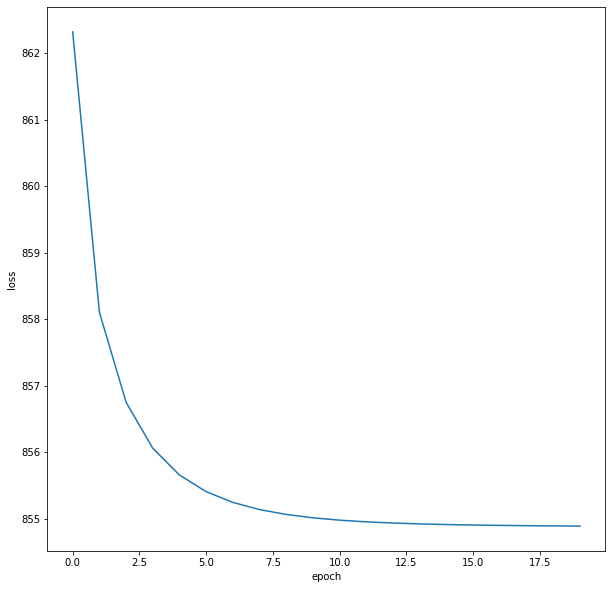

method: Adam; 
 train MSE:854.74; 	 test R2:-0.0 
 test MSE:2679.22; 	 test R2:-0.09


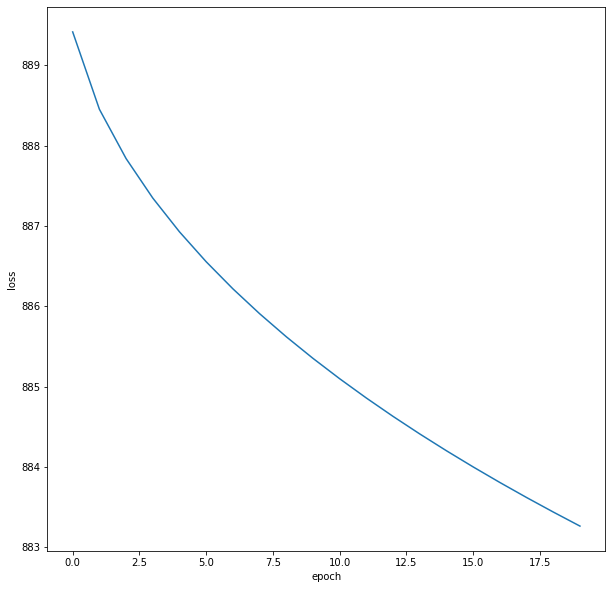

method: AdaGrad; 
 train MSE:883.17; 	 test R2:-0.04 
 test MSE:2826.46; 	 test R2:-0.15


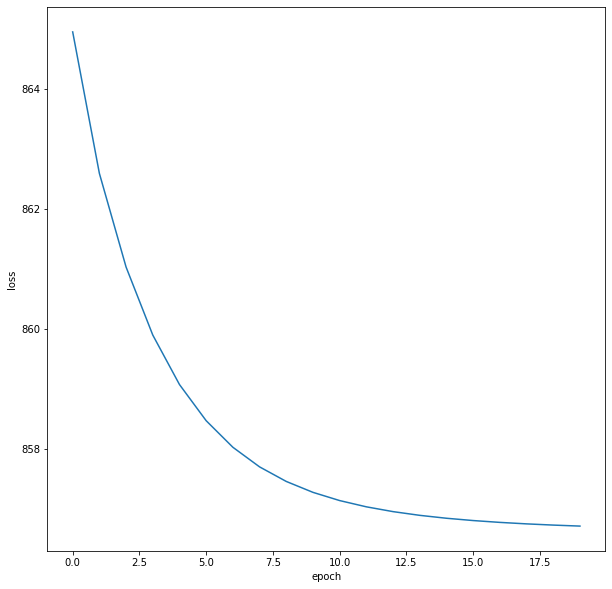

method: RMSProp; 
 train MSE:856.56; 	 test R2:-0.0 
 test MSE:2697.25; 	 test R2:-0.09


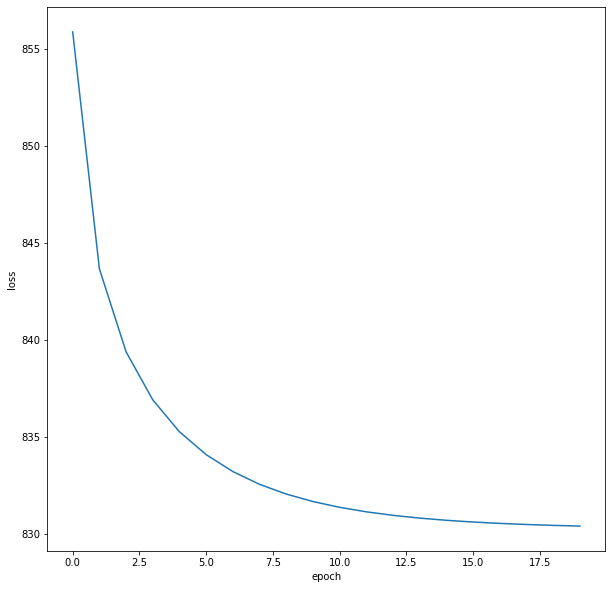

method: SGD; 
 train MSE:824.48; 	 test R2:0.03 
 test MSE:2691.64; 	 test R2:-0.09
method: Analytic_sol; 
 train MSE:830.37; 	 test R2:0.03 
 test MSE:2784.65; 	 test R2:-0.13


################################
5-FOLD CV:
################################


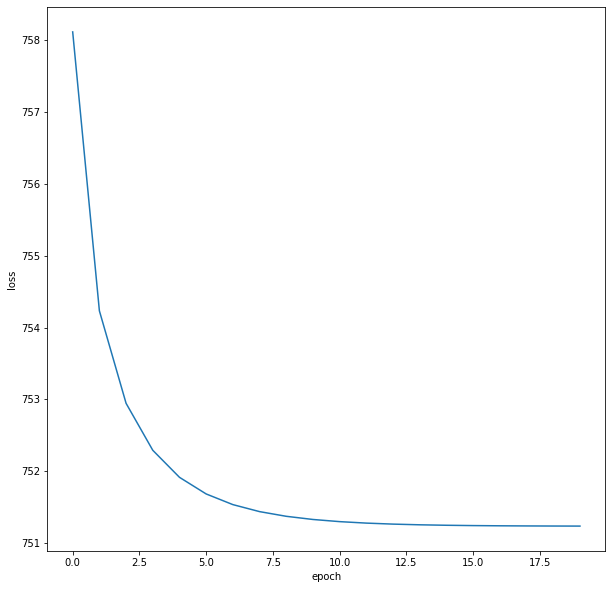

 method: Adam; fold №0 
 train MSE:751.1; 	 train R2:0.0 
 test MSE:1281.85; 	 test R2:-0.02 


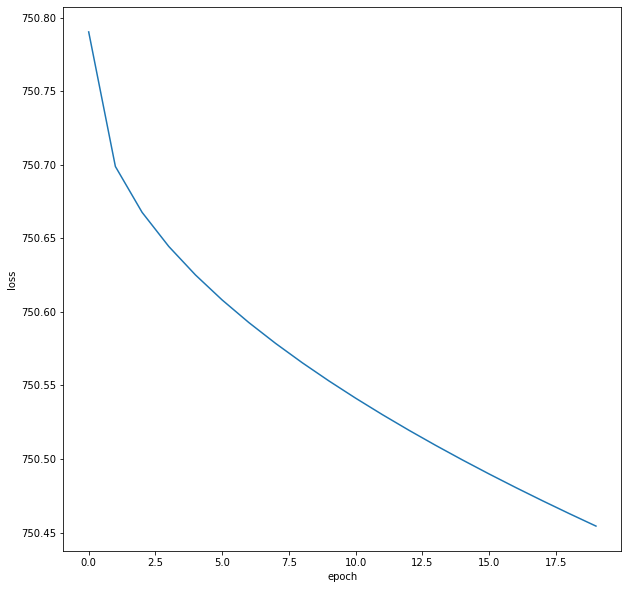

 method: AdaGrad; fold №0 
 train MSE:750.44; 	 train R2:0.0 
 test MSE:1258.77; 	 test R2:0.0 


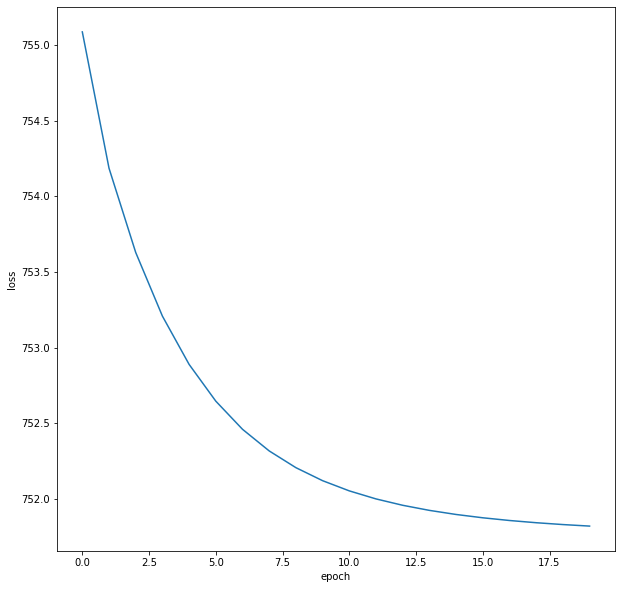

 method: RMSProp; fold №0 
 train MSE:751.64; 	 train R2:-0.0 
 test MSE:1277.18; 	 test R2:-0.01 


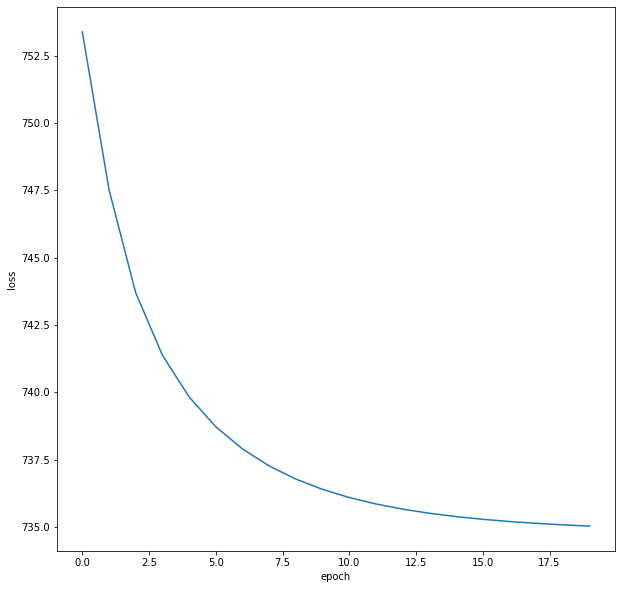

 method: SGD; fold №0 
 train MSE:733.11; 	 train R2:0.02 
 test MSE:1260.3; 	 test R2:0.0 
 method: Analytic_sol; fold №0 
 train MSE:747.17; 	 train R2:0.01 
 test MSE:1317.45; 	 test R2:-0.04 


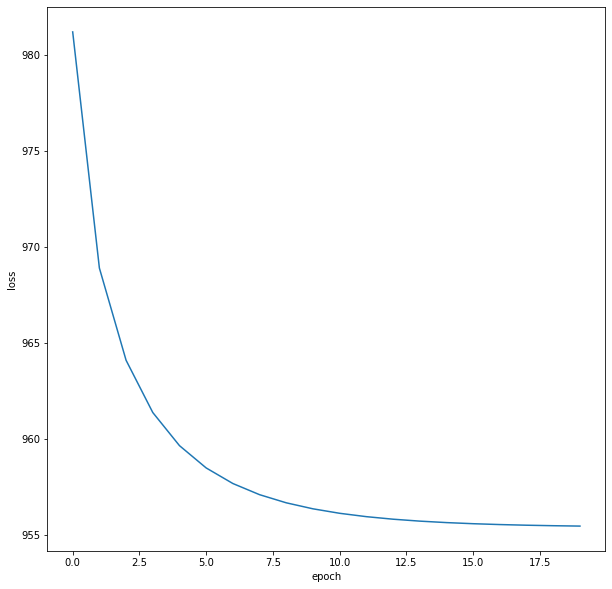

 method: Adam; fold №1 
 train MSE:954.32; 	 train R2:0.0 
 test MSE:451.14; 	 test R2:-0.03 


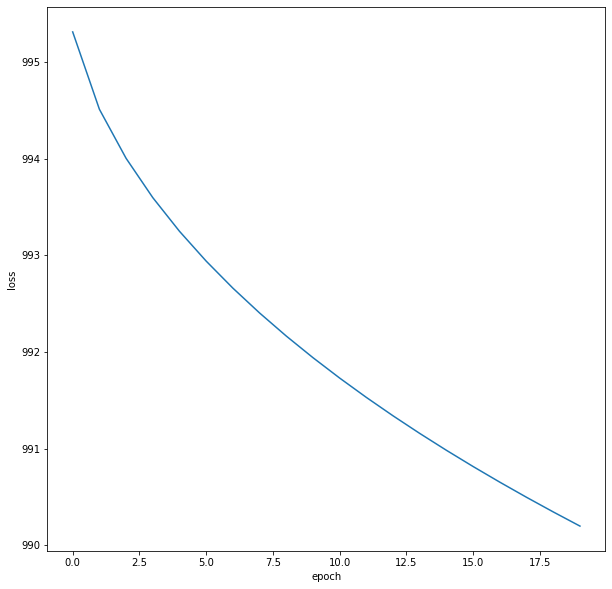

 method: AdaGrad; fold №1 
 train MSE:988.9; 	 train R2:-0.03 
 test MSE:439.37; 	 test R2:-0.0 


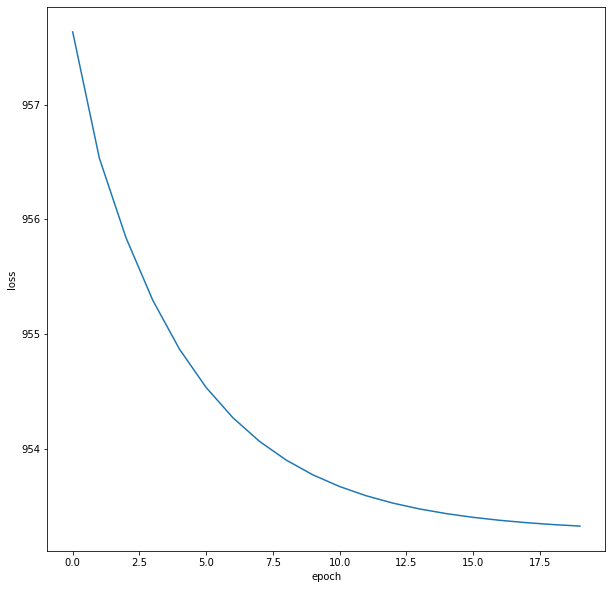

 method: RMSProp; fold №1 
 train MSE:952.19; 	 train R2:0.01 
 test MSE:447.41; 	 test R2:-0.02 


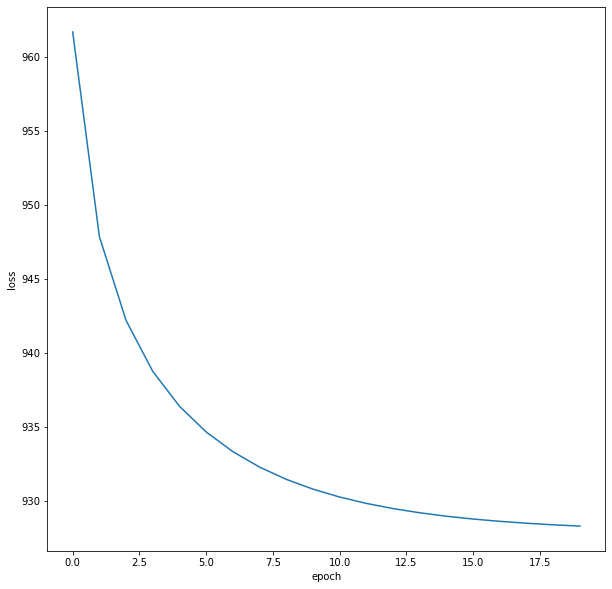

 method: SGD; fold №1 
 train MSE:916.23; 	 train R2:0.04 
 test MSE:485.48; 	 test R2:-0.11 
 method: Analytic_sol; fold №1 
 train MSE:962.91; 	 train R2:-0.01 
 test MSE:577.51; 	 test R2:-0.32 


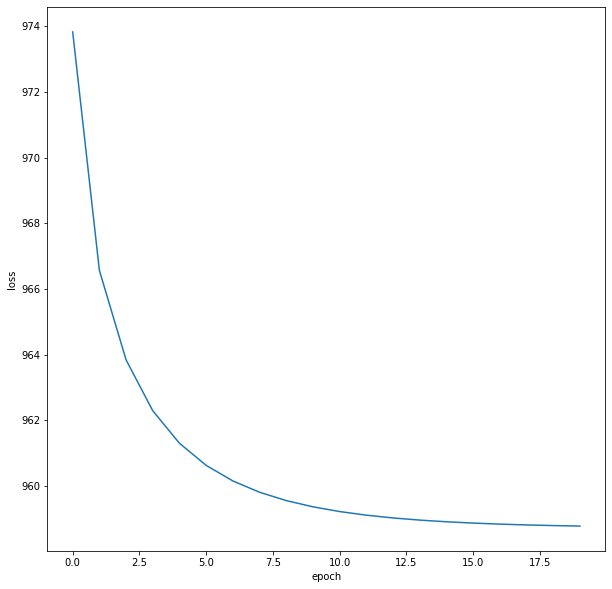

 method: Adam; fold №2 
 train MSE:960.6; 	 train R2:-0.0 
 test MSE:441.26; 	 test R2:-0.02 


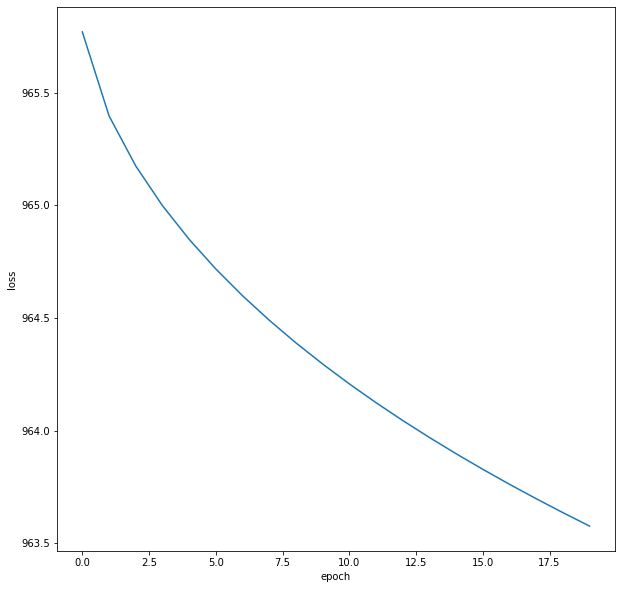

 method: AdaGrad; fold №2 
 train MSE:965.64; 	 train R2:-0.01 
 test MSE:431.8; 	 test R2:0.01 


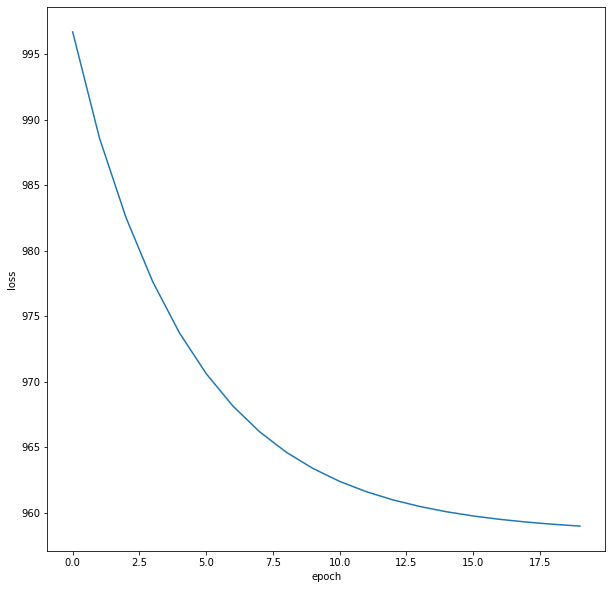

 method: RMSProp; fold №2 
 train MSE:960.78; 	 train R2:-0.0 
 test MSE:441.33; 	 test R2:-0.02 


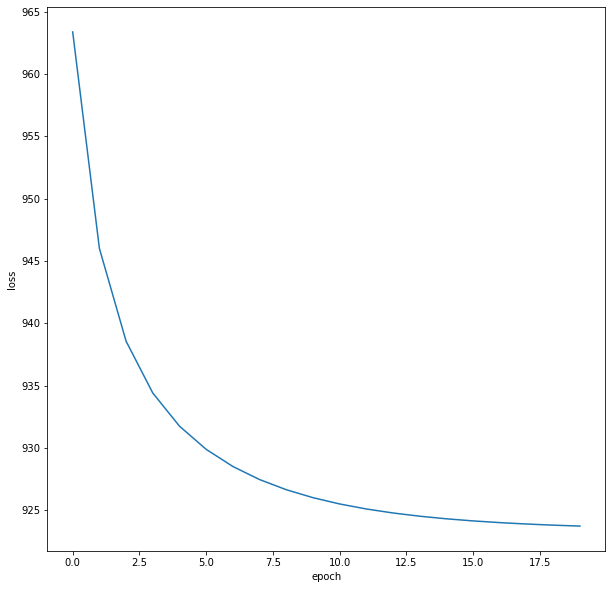

 method: SGD; fold №2 
 train MSE:915.78; 	 train R2:0.04 
 test MSE:469.03; 	 test R2:-0.08 
 method: Analytic_sol; fold №2 
 train MSE:1103.5; 	 train R2:-0.15 
 test MSE:652.4; 	 test R2:-0.5 


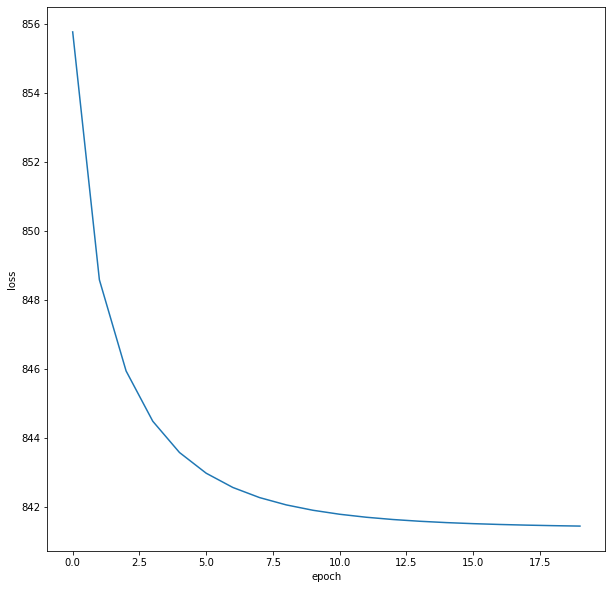

 method: Adam; fold №3 
 train MSE:840.32; 	 train R2:-0.01 
 test MSE:938.36; 	 test R2:-0.0 


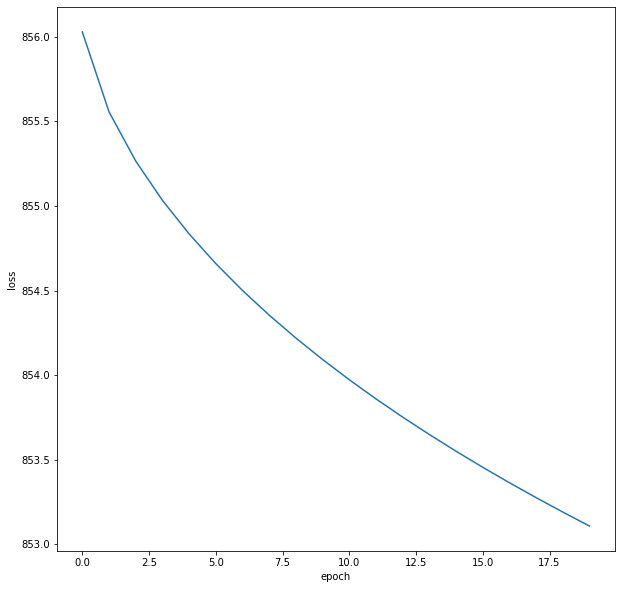

 method: AdaGrad; fold №3 
 train MSE:852.03; 	 train R2:-0.02 
 test MSE:949.91; 	 test R2:-0.01 


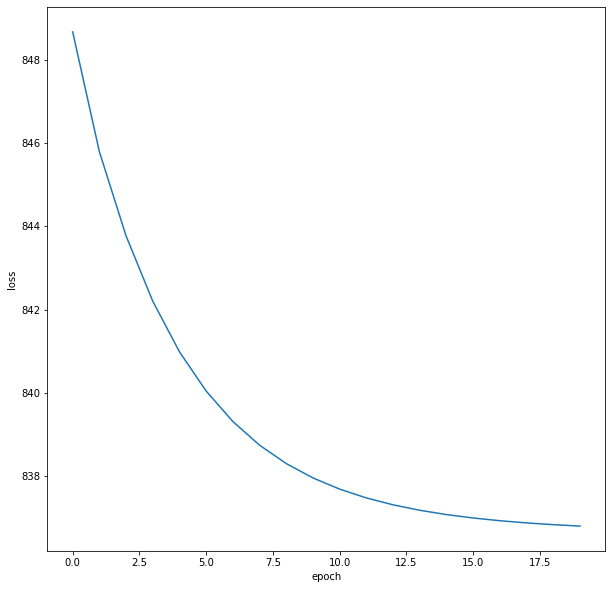

 method: RMSProp; fold №3 
 train MSE:835.74; 	 train R2:-0.0 
 test MSE:942.04; 	 test R2:-0.0 


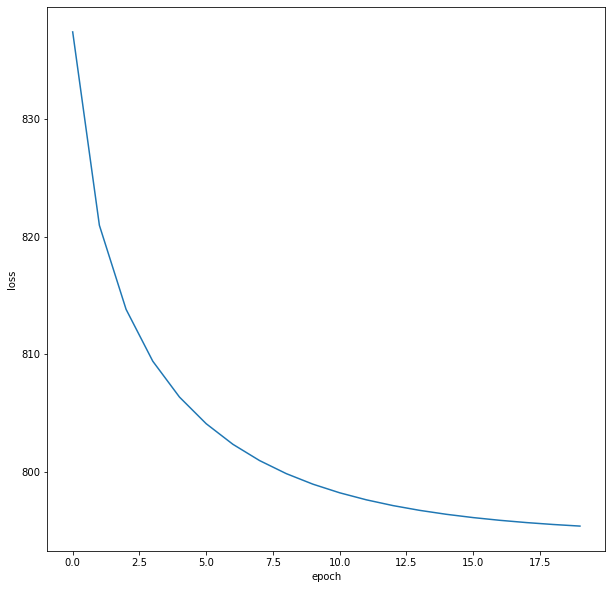

 method: SGD; fold №3 
 train MSE:787.74; 	 train R2:0.06 
 test MSE:994.52; 	 test R2:-0.06 
 method: Analytic_sol; fold №3 
 train MSE:821.5; 	 train R2:0.02 
 test MSE:1023.8; 	 test R2:-0.09 


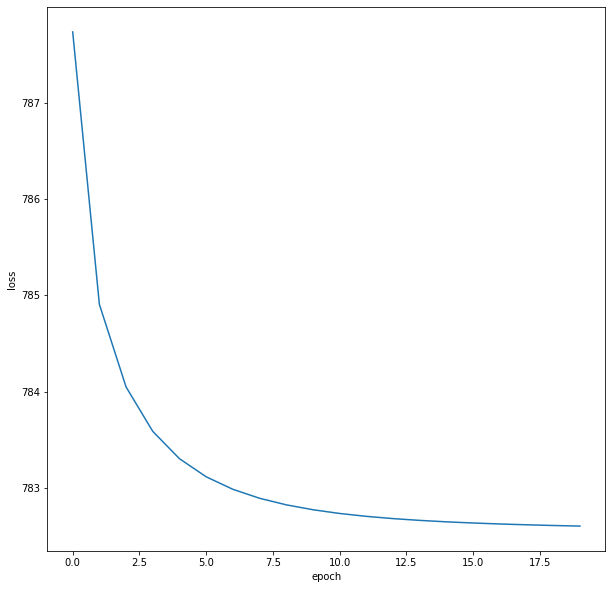

 method: Adam; fold №4 
 train MSE:782.44; 	 train R2:-0.01 
 test MSE:1172.48; 	 test R2:-0.01 


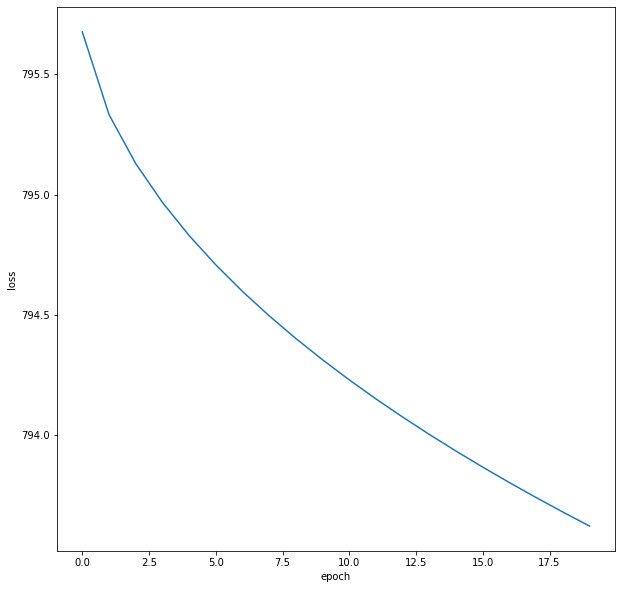

 method: AdaGrad; fold №4 
 train MSE:793.59; 	 train R2:-0.02 
 test MSE:1205.19; 	 test R2:-0.04 


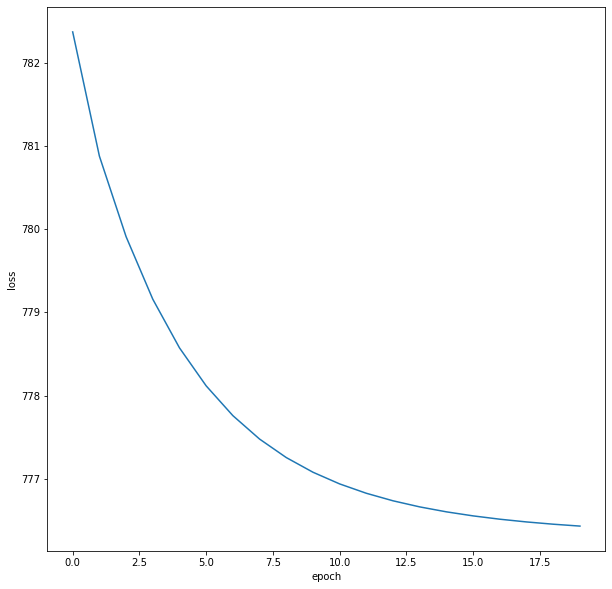

 method: RMSProp; fold №4 
 train MSE:776.33; 	 train R2:0.0 
 test MSE:1183.67; 	 test R2:-0.02 


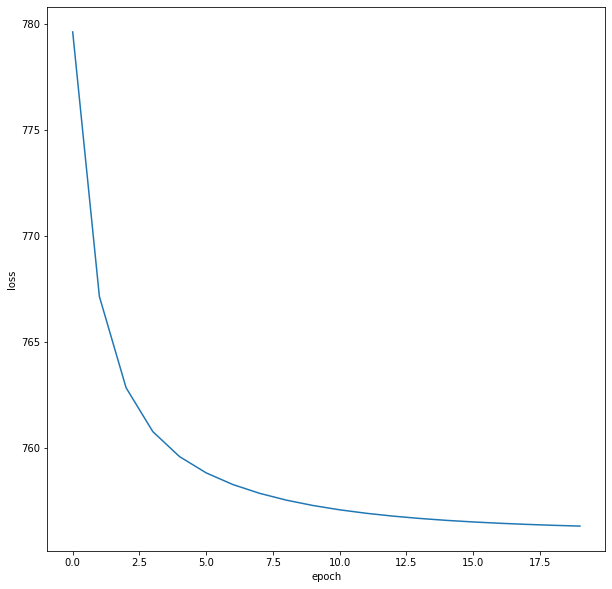

 method: SGD; fold №4 
 train MSE:747.71; 	 train R2:0.04 
 test MSE:1173.01; 	 test R2:-0.01 
 method: Analytic_sol; fold №4 
 train MSE:868.21; 	 train R2:-0.12 
 test MSE:1298.96; 	 test R2:-0.12 


In [13]:
train(params, [Adam, AdaGrad, RMSProp, SGD, Analytic_sol], [MSE_metric, R2_metric], res, MmScaler())

Сильный разброс метрик обоснован использованием небольших выборок, объем которых ограничивается производительностью чистого python. 

# **Сравнение с sklearn**

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
train_dataset = pd.read_csv('data/train_dataset.csv').sample(100000)
test_dataset = pd.read_csv('data/test_dataset.csv').sample(100000)

In [ ]:
x_train = train_dataset.drop(['DepDelay'], axis=1).to_numpy()
y_train = train_dataset['DepDelay'].to_numpy()

x_test = test_dataset.drop(['DepDelay'], axis=1).to_numpy()
y_test = test_dataset['DepDelay'].to_numpy()

In [ ]:
scaler = MinMaxScaler()

In [ ]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
model = SGDRegressor(penalty='l2')

In [ ]:
model.fit(x_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
y_pred = model.predict(x_test)

mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
r2 = r2_score(y_true=y_test, y_pred=y_pred)

In [ ]:
print(f'MSE: {mse},\nR2: {r2}.')

MSE: 1799.083849499026,
R2: 0.00687631115990972.
